In [ ]:
import torch
import numpy as np
import os
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [ ]:
# для воспроизводимости результатов
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed(30)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Распаковка данных

Разархивируем на месте, потому что так быстрее

In [ ]:
!unzip -q /content/drive/MyDrive/CCPD2019-dl1.zip
!ls CCPD2019-dl1

test  train


Посмотрим на названия


In [ ]:
!ls CCPD2019-dl1/test

0042-皖AD130W.jpg  0235-皖A0V262.jpg  0325-皖AKZ948.jpg  0442-皖A85Z23.jpg
0044-皖AUT267.jpg  0235-皖A268V3.jpg  0325-皖AL0136.jpg  0442-皖AC2626.jpg
0045-皖AVD028.jpg  0235-皖A60455.jpg  0325-皖AL738B.jpg  0442-皖ACS110.jpg
0045-皖MZ4882.jpg  0235-皖A825X1.jpg  0325-皖AL9G36.jpg  0442-皖AHY786.jpg
0046-皖RL222P.jpg  0235-皖A83E36.jpg  0325-皖APN680.jpg  0442-皖AK0269.jpg
0047-皖AGC276.jpg  0235-皖A97Z95.jpg  0325-皖AR067X.jpg  0442-皖AP332L.jpg
0047-皖AU0194.jpg  0235-皖AAC682.jpg  0325-皖AT0207.jpg  0442-皖AR9M77.jpg
0048-皖AC880Y.jpg  0235-皖ACP055.jpg  0325-皖AUG555.jpg  0442-皖HP999X.jpg
0050-皖ATG568.jpg  0235-皖AD1G35.jpg  0325-皖AV0600.jpg  0442-皖KPY882.jpg
0051-皖A41476.jpg  0235-皖AD7344.jpg  0325-皖AV5A99.jpg  0443-皖A001E5.jpg
0053-皖AH8V95.jpg  0235-皖AE5G66.jpg  0325-皖AWF389.jpg  0443-皖A05196.jpg
0054-皖AE0901.jpg  0235-皖AG9108.jpg  0325-皖Q05275.jpg  0443-皖A311J7.jpg
0054-皖AJ7532.jpg  0235-皖AJX876.jpg  0326-皖A166F4.jpg  0443-皖A562F1.jpg
0054-皖ATV235.jpg  0235-皖AQ6161.jpg  0326-皖A5H114.jpg  0443-皖A58448.jpg
0056-皖

*   Each LP number is comprised of a Chinese character, a letter, and five letters or numbers. A valid Chinese license plate consists of seven characters: province (1 character), alphabets (1 character), alphabets+digits (5 characters)

In [ ]:
!ls

CCPD2019-dl1  drive  sample_data


In [ ]:
from pathlib import Path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dir = Path('CCPD2019-dl1/train')
test_dir = Path('CCPD2019-dl1/test')
train_files = list(train_dir.rglob('*.jpg'))
test_files = list(test_dir.rglob('*.jpg'))
print('Train size:', len(train_files))
print('Test size:', len(test_files))

Train size: 199980
Test size: 9999


# Посмотрим на данные

In [ ]:
class LP_Dataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в тензоры
    """
    def __init__(self, files):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)

        self.len_ = len(self.files)

        self.labels = [path.name for path in self.files]
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        x = self.load_sample(self.files[index])
        x = transform(x)

        label = self.labels[index]
        return x, label

Вывод размеров нескольких изображений показал, что размеры у всех разные, но примерно в одном диапазоне.
Также вывод нескольких тензоров показал, что все изображения уже нормализованы:

In [ ]:
train_dataset = LP_Dataset(train_files)

Так как размеры трэйна велики, то посчитаем на произвольных картинках трэйна

In [ ]:
from numpy.matrixlib.defmatrix import N
w_all, h_all, mean, total = 0, 0, [0, 0, 0], 0
t = np.random.randint(0, 199979, 20000)
for i in t:
  for j in range(3):
    mean[j] += train_dataset[i][0][j].sum()
    total += train_dataset[i][0].shape[1] * train_dataset[i][0].shape[2]
  n, w, h = train_dataset[i][0].shape
  w_all += w
  h_all += h

In [ ]:
mean = [x/total for x in mean]
std = [0, 0, 0]
for i in t:
  for j in range(3):
    std[j] += train_dataset[i][0][j].mean() - mean[j]
std = [x/total for x in std]
print(w_all/20000, h_all/20000, mean, std)
del train_dataset
del total
del t

85.0812 250.8 [tensor(0.0885), tensor(0.1413), tensor(0.2097)] [tensor(2.6549e-06), tensor(4.2159e-06), tensor(6.2737e-06)]


# Обработка данных с кодированием, масштабированием

Есть ощущение, что первые 4 цифры в названии изображения что-то обозначают, однако не хочу слепо верить этому, поэтому кодирую только само значение номера.

In [ ]:
#resc_w, resc_h = w_all, h_all
resc = 384 # для модели нужны такие размеры
mean = [0.0885, 0.1413, 0.2097]
std = [2.6549e-06, 4.2159e-06, 6.2737e-06]

Кодируем номер автомобиля в матрицу стбц-стр = символ-позиция. На пересечении единицу ставим.
Беру непрямоугольный массив, чтобы было меньше поводов для ошибки сети. 

In [ ]:
import itertools
def flatten(arr):
  return list(itertools.chain.from_iterable(arr))

provinces = dict(zip(["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼",
                      "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"], range(34)))
alphabets = dict(zip(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'O'],
                     range(25)))
ads = dict(zip(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O'], range(35)))

# кажется, буква О заменяет плохораспознаваемые символы, так что оставим ёё
def encode(name):
  name = name.split(sep='-')[1][:-4]
  a = [[0]*34, [0]*25] + [[0]*35 for i in range(5)]
  a[0][ provinces[name[0]] ] = 1
  a[1][ alphabets[name[1]] ] = 1
  for i in range(2, 7):
    a[i][ ads[name[i]] ] = 1
  return flatten(a)

# сразу напишем декодер

inverse_provinces = {v: k for k, v in provinces.items()}
inverse_alphabets = {v: k for k, v in alphabets.items()}
inverse_ads = {v: k for k, v in ads.items()}

def decode(arrs, names= False):
  n = arrs.size()[0]
  out = torch.zeros(n, 234, device= device)
  
  for i in range(n):
    name = ''
    arr = arrs[i]

    # для превращения вероятностей принадлежности к классу в метки классов=символов
    pred = torch.zeros(234, device= device)
    pred[torch.argmax(arr[:34])] = 1
    pred[torch.argmax(arr[34:59])] = 1
    for j in range(5):
       pred[torch.argmax(arr[59 + 35*j: 94 + 35*j])] = 1
    out[i] = pred
    
    if names:
      # это для превращения  векторов с единицами в номера автомобилей
      ind = torch.nonzero(arr[:34])[0].item()  # индекс 1 в части массива с провинцией
      name += inverse_provinces[ind]
  
      ind = torch.nonzero(arr[34:59])[0].item() # индекс 1 в части массива с буквой
      name += inverse_alphabets[ind]

      for j in range(5):
        ind = torch.nonzero(arr[59 + 35*j: 94 + 35*j])[0].item()
        name += inverse_ads[ind]

      out[i] = name
      del arr
  return out

In [ ]:
class LP_Dataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)

        self.len_ = len(self.files)
        self.labels = torch.Tensor([encode(path.name) for path in self.files])
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = transform(x)
        label = self.labels[index]
        return x, label
  
    def _prepare_sample(self, image):   # наставляет паддинг, чтобы не изменялись пропорции изображения
        w, h = image.size
        max_wh = np.max([w, h])
        min_wh = np.min([w, h])
  
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)

        image = transforms.functional.pad(image, padding, 0, 'constant')    
        image = image.resize((resc, resc)) # ресайзим для нашей сети
        return np.array(image)

In [ ]:
train_dataset = LP_Dataset(train_files)
test_dataset = LP_Dataset(test_files)

При добавлении аугментации часть картинок выводилась просто серой, с чем непонятно как бороться, так что оставлю без аугментации. Всё равно у всех картинок очень разное качество, так что модель научиться распознавать и их.

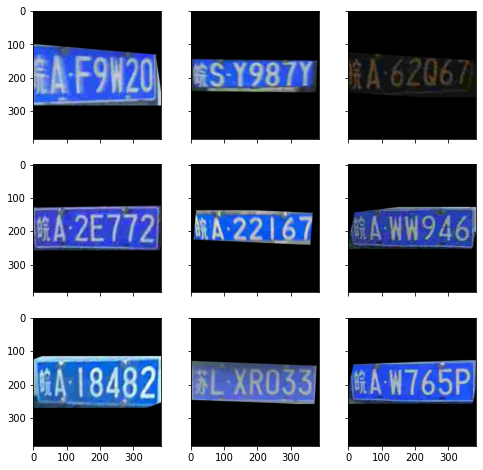

In [ ]:
import matplotlib.pyplot as plt

def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    plt_ax.grid(False)

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    im_tr = train_dataset[np.random.randint(0, 199979, 1)[0]]    
    imshow(im_tr[0], plt_ax=fig_x)

# Размер батча и эпохи

In [ ]:
batch_size = 16
n_epochs = 40
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Модель

В этой модели небольшое количество параметров и она очень быстрая, а так же ее точность высока.
я пробовала efficientnet b5, однако гпу быстро переполняется.

In [ ]:
from torchvision.models import mobilenet_v2
model = mobilenet_v2(weights= None)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
import torch.nn as nn
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features= 234,bias= True)
)
model = model.to(device)

# Обучение

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 33.6 MB/s eta 0:00:00


In [ ]:
import torchmetrics
metric = torchmetrics.functional.char_error_rate

In [ ]:
def eval_epoch(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    running_cer = 0
    processed_size = 0

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = decode(outputs)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        running_cer += metric(preds, labels)
        processed_size += inputs.size(0)
    test_loss = running_loss / processed_size
    test_acc = running_corrects.double() / processed_size
    test_cer = running_cer.double() /processed_size
    return test_loss, test_acc, test_cer

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    running_cer = 0
    processed_data = 0
    scheduler.step()         
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = decode(outputs)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        running_cer += metric(preds, labels)
        processed_data += inputs.size(0)
    
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    train_cer = running_cer.cpu().numpy() /processed_data
    return train_loss, train_acc, train_cer

In [ ]:
def gr(tr_acc, te_acc, tr_loss, te_loss, tr_cer, te_cer): # для построения графиков после каждой эпохи
  n = len(te_loss) + 1

  pb = plt.figure(figsize=(18, 3))
  pb.add_subplot(1, 3, 1)
  plt.plot(range(1, n), te_cer, label = 'test')
  plt.plot(range(1, n), tr_cer, label = 'train')
  plt.title('Char Error Rate')
  plt.xlabel('Epochs')
  plt.ylabel('CER')
  plt.legend(loc='best')

  pb.add_subplot(1, 3, 2)
  plt.plot(range(1, n), te_acc, label = 'test')
  plt.plot(range(1, n), tr_acc, label = 'train')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='best')

  pb.add_subplot(1, 3, 3)
  plt.plot(range(1, n), te_loss, label = 'test')
  plt.plot(range(1, n), tr_loss, label = 'train')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('loss')
  plt.legend(loc='best')

  plt.show()

In [ ]:
from torch.optim import lr_scheduler
from tqdm import tqdm, tqdm_notebook
from IPython.display import clear_output
def train(train_loader, val_loader, model, epochs, batch_size):

    best_model_wts = model.state_dict()
    best_acc = 0.0

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()
        optimizer_ft = torch.optim.Adam(model.parameters(), lr=1e-4)
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc, train_cer = fit_epoch(model, train_loader, criterion, opt, exp_lr_scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc, val_cer = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc,train_cer, val_loss, val_acc, val_cer))
            
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            print('Best val Acc: {:4f}'.format(best_acc))
            gr(train_acc, val_acc, train_loss, val_loss, train_cer, val_cer)
            if epoch < epochs - 1:
              clear_output(wait= True)

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return history

In [ ]:
history = train(train_loader, test_loader, model, n_epochs, batch_size)

epoch:   0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
epoch:   0%|          | 0/40 [04:27<?, ?it/s]


KeyboardInterrupt: ignored

Очень долго обучается, попробую написать простую сеть.

# Модель 2

In [ ]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten()
        )
  
        
        self.out = nn.Linear(18432, n_classes)
  
  
    def forward(self, x):
        x = self.conv(x)
        logits = self.out(x)
        return logits
model2 = SimpleCnn(234).to(device)

Тоже долго обучается. Полагаю из-за больших размеров трэйна

In [ ]:
history = train(train_loader, test_loader, model2, 5, batch_size)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
history = train(train_loader, test_loader, model2, 5, batch_size)